# Import Packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pearson Correlation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cudf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import keras_tuner as kt

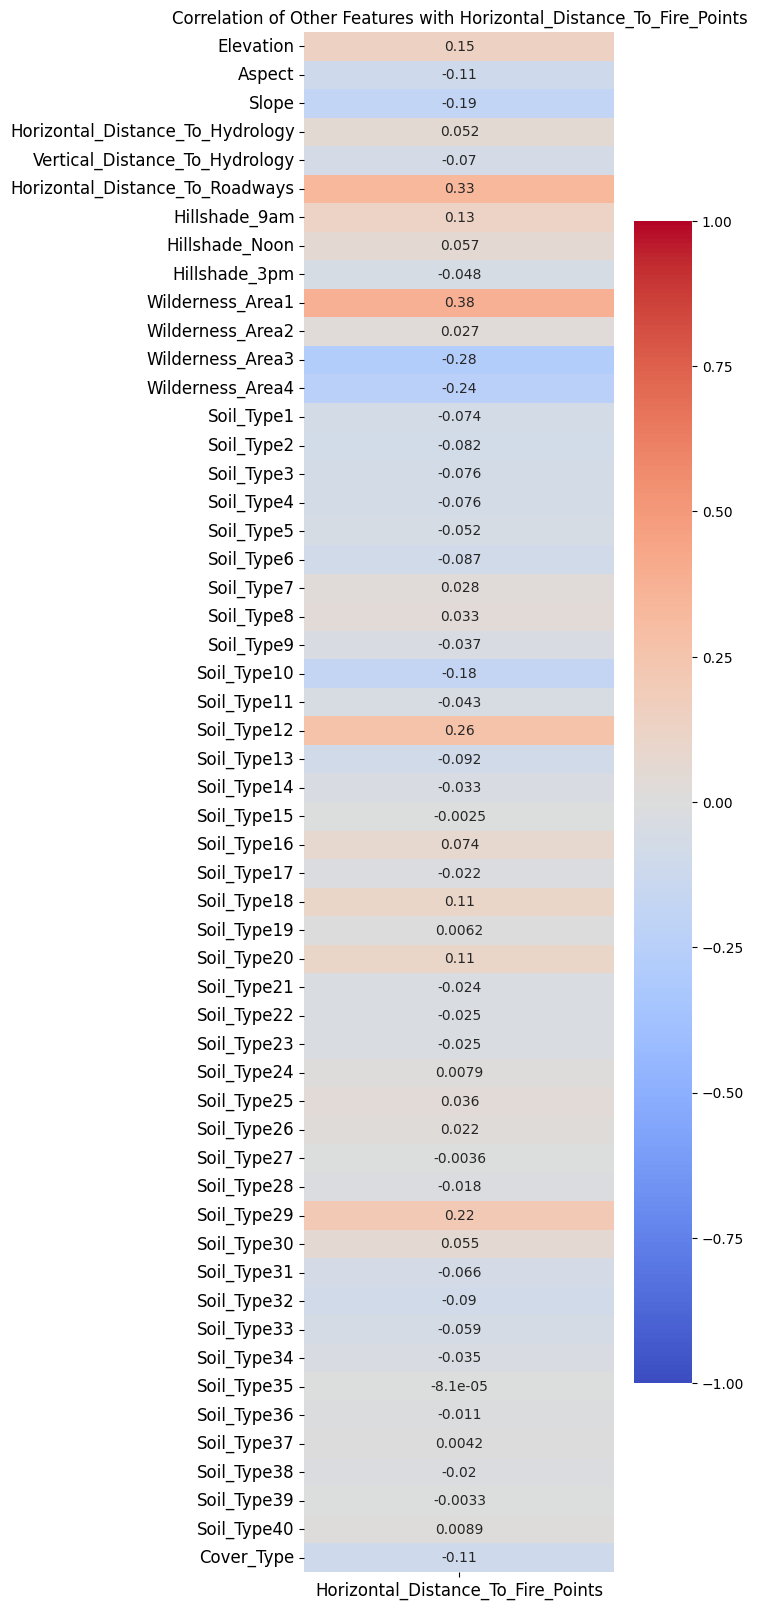

In [ ]:
df = cudf.read_csv('covtype.csv')
# df = cudf.read_csv('/content/drive/MyDrive/covtype.csv')

# Compute the correlation matrix
corr_matrix = df.corr()

# Extract correlations for 'Horizontal_Distance_To_Fire_Points'
horizontal_fire_corr = corr_matrix[['Horizontal_Distance_To_Fire_Points']].drop('Horizontal_Distance_To_Fire_Points')

# Convert CuDF DataFrame to Pandas DataFrame
horizontal_fire_corr_pandas = horizontal_fire_corr.to_pandas()

# Reshape the data into a 2D array
heatmap_data = horizontal_fire_corr_pandas.T  # Transpose to make it a single row

plt.figure(figsize=(5, 20)) 

sns.heatmap(horizontal_fire_corr_pandas, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=['Horizontal_Distance_To_Fire_Points'],
            yticklabels=horizontal_fire_corr_pandas.index, square=False)

plt.xticks(rotation=0, fontsize=12)  # Keep x-label horizontal
plt.yticks(rotation=0, ha="right", fontsize=12)  # Ensure y-labels are readable
plt.title("Correlation of Other Features with Horizontal_Distance_To_Fire_Points")
plt.show()

# Classification MLP


In [ ]:
X = df.drop('Horizontal_Distance_To_Fire_Points', axis=1)
y = df['Horizontal_Distance_To_Fire_Points']

# use MSE/MAE to evaluate the performance of our model in creating a predicted distance from fire, minimize this to try and get the closest predicted distance

# Direct Method: Put Horizontal_Distance_To_Fire_Points through a threshold (1600 m) before training
y_direct = (df['Horizontal_Distance_To_Fire_Points'] <= 1600).astype(int)  # Binary target
y_direct.head()
X = X.to_pandas().values
y_direct = y_direct.to_pandas().values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_direct, test_size=0.2, random_state=42)

mlp = MLPClassifier(
    solver='sgd',              # Stochastic Gradient Descent
    random_state=42,           # Random seed for reproducibility
    activation='logistic',     # Sigmoid activation
    learning_rate_init=0.4,    # Initial learning rate
    batch_size=100,            # Mini-batch size
    hidden_layer_sizes=(23, 17, 13),  # Architecture: 3 hidden layers
    max_iter=500               # Maximum number of iterations
)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8432
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     62497
           1       0.84      0.82      0.83     53706

    accuracy                           0.84    116203
   macro avg       0.84      0.84      0.84    116203
weighted avg       0.84      0.84      0.84    116203

Confusion Matrix:
[[53981  8516]
 [ 9706 44000]]


In [ ]:
# Standardize the features (PCA requires standardized data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.90)  # Retain 85% of the variance
X_pca = pca.fit_transform(X_scaled)

# Check the number of components retained
print(f"Number of components after PCA: {pca.n_components_}")

y_direct = (df['Horizontal_Distance_To_Fire_Points'] <= 1600).astype(int)  # Binary target
y_direct = y_direct.to_pandas().values

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_direct, test_size=0.2, random_state=42)

mlp = MLPClassifier(
    solver='sgd',              # Stochastic Gradient Descent
    random_state=42,           # Random seed for reproducibility
    activation='logistic',     # Sigmoid activation
    learning_rate_init=0.4,    # Initial learning rate
    batch_size=100,            # Mini-batch size
    hidden_layer_sizes=(23, 17, 13),  # Architecture: 3 hidden layers
    max_iter=500               # Maximum number of iterations
)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Number of components after PCA: 40
Accuracy: 0.8140
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     62497
           1       0.80      0.79      0.80     53706

    accuracy                           0.81    116203
   macro avg       0.81      0.81      0.81    116203
weighted avg       0.81      0.81      0.81    116203

Confusion Matrix:
[[52182 10315]
 [11297 42409]]


# Classification Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

X = df.drop('Horizontal_Distance_To_Fire_Points', axis=1)
y = df['Horizontal_Distance_To_Fire_Points']

# Direct Method: Put Horizontal_Distance_To_Fire_Points through a threshold (1600 m) before training
y_direct = (df['Horizontal_Distance_To_Fire_Points'] <= 1600).astype(int)  # Binary target
y_direct.head()
X = X.to_pandas().values
y_direct = y_direct.to_pandas().values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_direct, test_size=0.2, random_state=42)

mlp = MLPClassifier(
    solver='sgd',              # Stochastic Gradient Descent
    random_state=42,           # Random seed for reproducibility
    activation='logistic',     # Sigmoid activation
    learning_rate_init=0.4,    # Initial learning rate
    batch_size=100,            # Mini-batch size
    hidden_layer_sizes=(23, 17, 13),  # Architecture: 3 hidden layers
    max_iter=500               # Maximum number of iterations
)

param_grid = {
    'hidden_layer_sizes': [(23, 17, 13),
        (50,),  # 1 hidden layer with 50 neurons
        (50, 25),  # 2 hidden layers with 50 and 25 neurons
        (50, 25, 10),  # 3 hidden layers with 50, 25, and 10 neurons],
    ],
    'learning_rate_init': [0.05, 0.1, 0.25, 0.4],
    'max_iter': [250, 500, 1000],
}

# Define Grid Search
grid_search = GridSearchCV(
    estimator=mlp,  # Model to tune
    param_grid=param_grid,  # Hyperparameter grid
    scoring='accuracy',  # Metric to optimize
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/andrew/miniconda3/envs/rapids_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/andrew/miniconda3/envs/rapids_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/andrew/miniconda3/envs/rapids_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/andrew/miniconda3/envs/rapids_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't 

[CV] END hidden_layer_sizes=(23, 17, 13), learning_rate_init=0.05, max_iter=1000; total time=18.7min
[CV] END hidden_layer_sizes=(23, 17, 13), learning_rate_init=0.1, max_iter=1000; total time=12.5min
[CV] END hidden_layer_sizes=(23, 17, 13), learning_rate_init=0.4, max_iter=500; total time= 4.5min
[CV] END hidden_layer_sizes=(50,), learning_rate_init=0.05, max_iter=500; total time=14.7min
[CV] END hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=1000; total time=16.3min
[CV] END hidden_layer_sizes=(50,), learning_rate_init=0.4, max_iter=250; total time= 6.2min
[CV] END hidden_layer_sizes=(50, 25), learning_rate_init=0.05, max_iter=250; total time=11.1min
[CV] END hidden_layer_sizes=(50, 25), learning_rate_init=0.1, max_iter=250; total time=10.7min
[CV] END hidden_layer_sizes=(50, 25), learning_rate_init=0.1, max_iter=1000; total time=16.2min
[CV] END hidden_layer_sizes=(50, 25), learning_rate_init=0.4, max_iter=250; total time= 8.4min
[CV] END hidden_layer_sizes=(50, 25, 10)

In [ ]:
# Train the best model
best_model = grid_search.best_estimator_  # or random_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.9060
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     62497
           1       0.91      0.88      0.90     53706

    accuracy                           0.91    116203
   macro avg       0.91      0.90      0.91    116203
weighted avg       0.91      0.91      0.91    116203

Confusion Matrix:
[[57793  4704]
 [ 6217 47489]]


# MLP Regressor (Doesn't Work)


In [ ]:
X = df.drop('Horizontal_Distance_To_Fire_Points', axis=1)
y = df['Horizontal_Distance_To_Fire_Points']

# use MSE/MAE to evaluate the performance of our model in creating a predicted distance from fire, minimize this to try and get the closest predicted distance

# Direct Method: Put Horizontal_Distance_To_Fire_Points through a threshold (1600 m) before training
# y_direct = (df['Horizontal_Distance_To_Fire_Points'] <= 1600).astype(int)  # Binary target
# y_direct.head()
X = X.to_pandas().values
y = y.to_pandas().values.reshape(-1, 1)

scaler = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(23, 17, 13),  # Architecture: 3 hidden layers
    activation='logistic',             # Sigmoid activation
    solver='sgd',                      # Stochastic Gradient Descent
    learning_rate_init=0.4,            # Initial learning rate
    batch_size=100,                    # Mini-batch size
    max_iter=500,                      # Maximum number of iterations
    random_state=42                    # Random seed for reproducibility
)

mlp_regressor.fit(X_train, y_train)

y_pred_scaled = mlp_regressor.predict(X_test)
print(y_pred_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test)
print(y_pred)
# Apply threshold to classify fire risk
threshold = 1600
# threshold_scaled = scaler_y.transform([[1600]])[0, 0]
""" Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70     62497
           1       1.00      0.00      0.01     53706

    accuracy                           0.54    116203
   macro avg       0.77      0.50      0.35    116203
weighted avg       0.75      0.54      0.38    116203
"""
# threshold_scaled = scaler.fit_transform(threshold.reshape(1, -1))
fire_risk_pred = (y_pred <= threshold).astype(int)
fire_risk_true = (y_test <= threshold).astype(int)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Regression MSE: {mse:.4f}")
print(f"Regression MAE: {mae:.4f}")

# Calculate classification metrics
accuracy = accuracy_score(fire_risk_true, fire_risk_pred)
print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(fire_risk_true, fire_risk_pred))
print("Confusion Matrix:")
print(confusion_matrix(fire_risk_true, fire_risk_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.50244466 0.36900023 0.38675187 ... 0.59563335 0.64815508 0.63469801]
[[3604.03555352]
 [2646.83864415]
 [2774.17113655]
 ...
 [4272.47804997]
 [4649.21635344]
 [4552.68884255]]
Regression MSE: 2712950.5119
Regression MAE: 1437.8093
Classification Accuracy: 0.5397
Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70     62497
           1       1.00      0.00      0.01     53706

    accuracy                           0.54    116203
   macro avg       0.77      0.50      0.35    116203
weighted avg       0.75      0.54      0.38    116203

Confusion Matrix:
[[62497     0]
 [53488   218]]


# TensorFlow Regression ANN


In [ ]:
# Prepare the data
X = df.drop('Horizontal_Distance_To_Fire_Points', axis=1)
y = df['Horizontal_Distance_To_Fire_Points']

# Convert to numpy arrays
X = X.to_pandas().values
y = y.to_pandas().values.reshape(-1, 1)

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')  # Use MSE as the loss function (because of its lower score)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2)

# Predict distances
y_pred_scaled = model.predict(X_test)

# Inverse-transform the scaled predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test)

# Apply threshold to classify fire risk
threshold = 1600
fire_risk_pred = (y_pred <= threshold).astype(int)
fire_risk_true = (y_test <= threshold).astype(int)

# Evaluate regression performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Regression MSE: {mse:.4f}")
print(f"Regression MAE: {mae:.4f}")

# Evaluate classification performance
accuracy = accuracy_score(fire_risk_true, fire_risk_pred)
print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(fire_risk_true, fire_risk_pred))
print("Confusion Matrix:")
print(confusion_matrix(fire_risk_true, fire_risk_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.1103 - val_loss: 0.0958
Epoch 2/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0930 - val_loss: 0.0881
Epoch 3/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0881 - val_loss: 0.0842
Epoch 4/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0843 - val_loss: 0.0823
Epoch 5/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0814 - val_loss: 0.0790
Epoch 6/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0795 - val_loss: 0.0799
Epoch 7/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0780 - val_loss: 0.0779
Epoch 8/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0767 - val_loss: 0.0767
Epoch 9/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0754 - val_loss: 0.0750
Epoch 10/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0743 - val_loss: 0.0764
Epoch 11/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0739 - val_loss: 0.0734
Epoch 12/50
3719/37

Regression MSE: 549321.2435

Regression MAE: 460.0174

Classification Accuracy: 0.8441

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.87      0.86     62497
           1       0.85      0.81      0.83     53706

    accuracy                           0.84    116203
   macro avg       0.84      0.84      0.84    116203
weighted avg       0.84      0.84      0.84    116203

Confusion Matrix:

[[54541  7956]

 [10156 43550]]

# Tenserflow Regression PCA

In [ ]:
# Prepare the data
X = df.drop('Horizontal_Distance_To_Fire_Points', axis=1)
y = df['Horizontal_Distance_To_Fire_Points']

# Convert to numpy arrays
X = X.to_pandas().values
y = y.to_pandas().values.reshape(-1, 1)

scaler_y = MinMaxScaler()

y_scaled = scaler_y.fit_transform(y)

# Standardize the features (PCA requires standardized data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.85)  # Retain 85% of the variance
X_pca = pca.fit_transform(X_scaled)

# Check the number of components retained
print(f"Number of components after PCA: {pca.n_components_}")
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_scaled, test_size=0.2, random_state=42)


Number of components after PCA: 37


In [ ]:
# Define the model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use MSE as the loss function

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2)

# Predict distances
y_pred_scaled = model.predict(X_test)

# Inverse-transform the scaled predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test)

# Apply threshold to classify fire risk
threshold = 1600
fire_risk_pred = (y_pred <= threshold).astype(int)
fire_risk_true = (y_test <= threshold).astype(int)

# Evaluate regression performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Regression MSE: {mse:.4f}")
print(f"Regression MAE: {mae:.4f}")

# Evaluate classification performance
accuracy = accuracy_score(fire_risk_true, fire_risk_pred)
print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(fire_risk_true, fire_risk_pred))
print("Confusion Matrix:")
print(confusion_matrix(fire_risk_true, fire_risk_pred))

Epoch 1/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0293 - val_loss: 0.0185
Epoch 2/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0174 - val_loss: 0.0163
Epoch 3/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 4/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0146 - val_loss: 0.0141
Epoch 5/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 6/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 7/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0129 - val_loss: 0.0137
Epoch 8/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0127 - val_loss: 0.0131
Epoch 9/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 10/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 11/50
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 12/50
3719/3719

PCA of 85% of Variance:
Regression MSE: 484983.5957

Regression MAE: 479.1108

Classification Accuracy: 0.8350

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     62497
           1       0.83      0.80      0.82     53706

    accuracy                           0.83    116203

   macro avg       0.83      0.83      0.83    116203

weighted avg       0.83      0.83      0.83    116203


Confusion Matrix:

[[53850  8647]

 [10530 43176]]

 37 Features


PCA of 90% of Variance: Regression MSE: 482040.3344

Regression MAE: 483.9578

Classification Accuracy: 0.8337

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.89      0.85     62497
           1       0.86      0.77      0.81     53706

    accuracy                           0.83    116203

   macro avg       0.84      0.83      0.83    116203

weighted avg       0.84      0.83      0.83    116203


Confusion Matrix:

[[55649  6848]

 [12478 41228]]
 40 Features

PCA for 95% of Variance: Regression MSE: 489089.5157

Regression MAE: 485.5085

Classification Accuracy: 0.8310

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     62497
           1       0.82      0.81      0.82     53706

    accuracy                           0.83    116203

   macro avg       0.83      0.83      0.83    116203

weighted avg       0.83      0.83      0.83    116203


Confusion Matrix:

[[53219  9278]

 [10360 43346]]

43 Features

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install keras-tuner

# Regression Hyperparameter Tuning

In [ ]:
df = cudf.read_csv('/content/drive/MyDrive/covtype.csv')

# Prepare the data
X = df.drop('Horizontal_Distance_To_Fire_Points', axis=1)
y = df['Horizontal_Distance_To_Fire_Points']

# Convert to numpy arrays
X = X.to_pandas().values
y = y.to_pandas().values.reshape(-1, 1)

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

def build_model(hp):
    model = Sequential()

    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 3, 3)):  # Between 1 and 3 hidden layers
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=16, max_value=64, step=16),  # Tune the number of neurons
            activation=hp.Choice('activation', ['relu'])  # Tune the activation function
        ))

    model.add(Dense(1))  # Output layer (no activation for regression)

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_absolute_error'  # Use MAE for regression
    )
    return model
# Define the Random Search tuner
tuner = kt.RandomSearch(
    build_model,  # The build_model function
    objective='val_loss',  # Minimize validation loss
    max_trials=2,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per trial (to account for randomness)
    directory='my_tuning_dir',  # Directory to save tuning results
    project_name='regression_random_search',  # Project name
    overwrite=True  # Overwrite previous results
)

# Perform the search
tuner.search(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2, verbose=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2, verbose=2)

# Evaluate on the test set
y_pred_scaled = best_model.predict(X_test)

# Inverse-transform the scaled predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test)

# Apply threshold to classify fire risk
threshold = 1600
fire_risk_pred = (y_pred <= threshold).astype(int)
fire_risk_true = (y_test <= threshold).astype(int)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")


# Evaluate classification performance
accuracy = accuracy_score(fire_risk_true, fire_risk_pred)
print(f"Classification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(fire_risk_true, fire_risk_pred))
print("Confusion Matrix:")
print(confusion_matrix(fire_risk_true, fire_risk_pred))

Trial 2 Complete [00h 10m 36s]
val_loss: 0.07263179123401642

Best val_loss So Far: 0.060311704874038696
Total elapsed time: 00h 21m 02s
Best Hyperparameters: {'num_layers': 3, 'units_0': 64, 'activation': 'relu', 'units_1': 48, 'units_2': 16, 'learning_rate': 0.001}
Epoch 1/50
3719/3719 - 13s - 4ms/step - loss: 0.1011 - val_loss: 0.0930
Epoch 2/50
3719/3719 - 19s - 5ms/step - loss: 0.0893 - val_loss: 0.0856
Epoch 3/50
3719/3719 - 10s - 3ms/step - loss: 0.0837 - val_loss: 0.0815
Epoch 4/50
3719/3719 - 10s - 3ms/step - loss: 0.0805 - val_loss: 0.0808
Epoch 5/50
3719/3719 - 11s - 3ms/step - loss: 0.0781 - val_loss: 0.0788
Epoch 6/50
3719/3719 - 11s - 3ms/step - loss: 0.0765 - val_loss: 0.0782
Epoch 7/50
3719/3719 - 10s - 3ms/step - loss: 0.0752 - val_loss: 0.0728
Epoch 8/50
3719/3719 - 21s - 6ms/step - loss: 0.0742 - val_loss: 0.0746
Epoch 9/50
3719/3719 - 10s - 3ms/step - loss: 0.0729 - val_loss: 0.0730
Epoch 10/50
3719/3719 - 10s - 3ms/step - loss: 0.0719 - val_loss: 0.0728
Epoch 11/50

Trial 30 Complete [00h 09m 31s]
val_loss: 0.010904870927333832

Best val_loss So Far: 0.005303591955453157
Total elapsed time: 04h 19m 48s

Best Hyperparameters:
units_1: 256
activation_1: relu
batch_norm_1: False
dropout_1: 0.1
num_layers: 3
units_2: 80
activation_2: relu
batch_norm_2: False
dropout_2: 0.0
learning_rate: 0.00024097286033432963
loss_type: mean_squared_error
units_3: 32
activation_3: relu
batch_norm_3: False
dropout_3: 0.1
units_4: 64
activation_4: relu
batch_norm_4: False
dropout_4: 0.0
Epoch 1/200
4068/4068 - 7s - 2ms/step - loss: 0.0204 - val_loss: 0.0171 - learning_rate: 2.4097e-04
Epoch 2/200
4068/4068 - 6s - 1ms/step - loss: 0.0164 - val_loss: 0.0146 - learning_rate: 2.4097e-04
Epoch 3/200
4068/4068 - 6s - 1ms/step - loss: 0.0147 - val_loss: 0.0129 - learning_rate: 2.4097e-04
Epoch 4/200
4068/4068 - 5s - 1ms/step - loss: 0.0137 - val_loss: 0.0124 - learning_rate: 2.4097e-04
Epoch 5/200
4068/4068 - 5s - 1ms/step - loss: 0.0130 - val_loss: 0.0116 - learning_rate: 2.

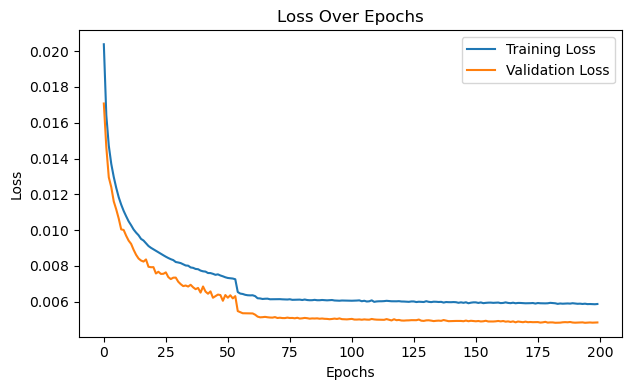

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 549us/step
Test MSE: 250834.1864
Test RMSE: 500.8335
Test MAE: 315.6917
R-squared: 0.8557

Classification Accuracy: 0.8973
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     46729
           1       0.89      0.89      0.89     40423

    accuracy                           0.90     87152
   macro avg       0.90      0.90      0.90     87152
weighted avg       0.90      0.90      0.90     87152

Confusion Matrix:
[[42210  4519]
 [ 4429 35994]]


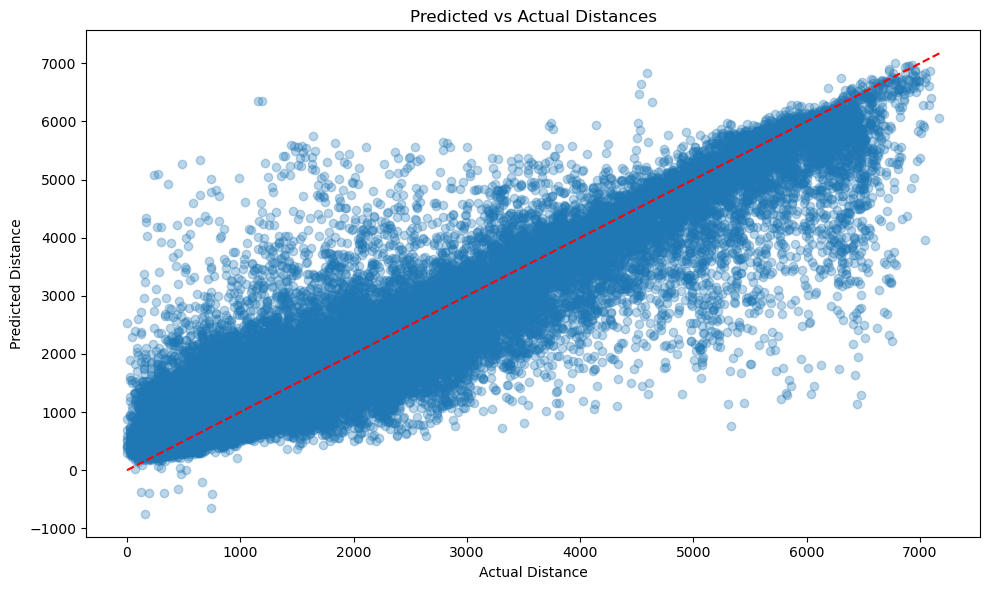

In [ ]:
# Load the data
df = pd.read_csv('covtype.csv')

# Prepare the data
X = df.drop('Horizontal_Distance_To_Fire_Points', axis=1)
y = df['Horizontal_Distance_To_Fire_Points']

# Convert to numpy arrays
X = X.values
y = y.values.reshape(-1, 1)

# Min-Max Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split the data with a dedicated validation set
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the model-building function with hyperparameters to tune
def build_model(hp):
    model = Sequential()

    # Tune number of units in first layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_1', values=['relu']),
        input_shape=(X_train.shape[1],)
    ))

    # Tune whether to use batch normalization
    if hp.Boolean('batch_norm_1'):
        model.add(BatchNormalization())

    # Tune dropout rate
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Tune number of hidden layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        # Tune number of units
        model.add(Dense(
            units=hp.Int(f'units_{i+2}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'activation_{i+2}', values=['relu'])
        ))

        # Tune whether to use batch normalization
        if hp.Boolean(f'batch_norm_{i+2}'):
            model.add(BatchNormalization())

        # Tune dropout rate
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.3, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Tune loss function
    loss_type = hp.Choice('loss_type', values=['mean_squared_error', 'mean_absolute_error'])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_type
    )

    return model

# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Define the Bayesian Optimization tuner (more efficient than Random Search)
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=30,  # Increased from 2 to 30
    executions_per_trial=1,
    directory='improved_tuning_dir',
    project_name='regression_bayesian_opt',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Perform the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=100,  # Maximum epochs per trial
    batch_size=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Define callbacks for final training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)
]

# Train the best model
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=2
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

if 'lr' in history.history:
    plt.subplot(1, 2, 2)
    plt.semilogy(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate (log scale)')

plt.tight_layout()
plt.show()

# Evaluate on the test set
y_pred_scaled = best_model.predict(X_test)

# Inverse-transform the scaled predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# Calculate regression metrics
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_test_original - y_pred)**2) / np.sum((y_test_original - np.mean(y_test_original))**2))

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

# Apply threshold to classify fire risk
threshold = 1600
fire_risk_pred = (y_pred <= threshold).astype(int)
fire_risk_true = (y_test_original <= threshold).astype(int)

# Evaluate classification performance
accuracy = accuracy_score(fire_risk_true, fire_risk_pred)
print(f"\nClassification Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(fire_risk_true, fire_risk_pred))
print("Confusion Matrix:")
print(confusion_matrix(fire_risk_true, fire_risk_pred))

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--')
plt.xlabel('Actual Distance')
plt.ylabel('Predicted Distance')
plt.title('Predicted vs Actual Distances')
plt.tight_layout()
plt.show()